<a href="https://colab.research.google.com/github/Sundara-Saravanan/SatSure-Geospatial-technical-test/blob/main/Saravanan_ndvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating NDVI Image Using sentinel data for Dharamapuri District, Tamilnadu

Installing the required Libraries

In [65]:
!pip install sentinelsat
!pip install rasterio
!pip install folium
!pip install geopandas
!pip install descartes 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import folium
import os
import numpy as np


from sentinelsat import SentinelAPI 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask

Loging in to the copernicus data hub

In [67]:
user = 'ssgis' 
password = 'saravanan@3045'

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

# Reading the Shapefile Geopandas and visualize it with Folium python library.


In [68]:
!wget https://www.dropbox.com/s/g24n4lme4722mfo/data.zip

--2022-11-15 06:53:01--  https://www.dropbox.com/s/g24n4lme4722mfo/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/g24n4lme4722mfo/data.zip [following]
--2022-11-15 06:53:02--  https://www.dropbox.com/s/raw/g24n4lme4722mfo/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb464ec4253426e3dd95090f8a9.dl.dropboxusercontent.com/cd/0/inline/BwyRALOP_wpKEOcvBQ68jsNCbP2RUePnlUOxEWUyujqbbJOyaaXWwrYvxPKK_lyU6nchmsoRmxbok5UUgYL2cZ64HZF23wkAjES3q0IVRjbxw3ww1ZvisBOLtm0naIspnDLOkkR015pbFRtZfdZecWADtpVUgeLZ3D610EWresLXXw/file# [following]
--2022-11-15 06:53:02--  https://ucb464ec4253426e3dd95090f8a9.dl.dropboxusercontent.com/cd/0/inline/BwyRALOP_wpKEOcvBQ68jsNCbP2RUePnlUOxEWUyujqbbJOyaaXWwrYvxPKK_lyU6nchmsoRmxbok5UUgYL2cZ64HZF2

In [69]:
!unzip 'data.zip'

Archive:  data.zip
replace data/.git/COMMIT_EDITMSG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/.git/COMMIT_EDITMSG  
  inflating: data/.git/config        
  inflating: data/.git/description   
  inflating: data/.git/HEAD          
  inflating: data/.git/hooks/applypatch-msg.sample  
  inflating: data/.git/hooks/commit-msg.sample  
  inflating: data/.git/hooks/fsmonitor-watchman.sample  
  inflating: data/.git/hooks/post-update.sample  
  inflating: data/.git/hooks/pre-applypatch.sample  
  inflating: data/.git/hooks/pre-commit.sample  
  inflating: data/.git/hooks/pre-merge-commit.sample  
  inflating: data/.git/hooks/pre-push.sample  
  inflating: data/.git/hooks/pre-rebase.sample  
  inflating: data/.git/hooks/pre-receive.sample  
  inflating: data/.git/hooks/prepare-commit-msg.sample  
  inflating: data/.git/hooks/push-to-checkout.sample  
  inflating: data/.git/hooks/update.sample  
  inflating: data/.git/index         
  inflating: data/.git/info/exclude  
  inflat

In [70]:
boundary = gpd.read_file('data/Dharmapuri/Dharmapuri.shp')
boundary

,cartodb_id,censuscode,dt_cen_cd,st_cen_cd,st_nm,district,geometry
0,148,630.0,29,33,Tamil Nadu,Dharmapuri,"POLYGON ((78.63535 12.17519, 78.64941 12.16151..."


In [ ]:
map = folium.Map([12.11, 78.2091], zoom_start=9)

folium.GeoJson(boundary).add_to(map)
map

With the above code, the boundary shapefile is read using Geopandas and called as boundary, then later created an empty base map in Folium centred around coordinates in the area, and defined it as map. Finally, The Geopanda data has been added to the base mapand we can visualize it.

Creating the footprint

In [72]:
bound = gpd.read_file('data/Dharmapuri/overlay.shp')

footprint = None
for i in bound['geometry']:
    footprint = i


Created a query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint (Area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20220501' and '20220530'

In [73]:
products = api.query(footprint,
                    date = ('20220501', '20220530'),
                    platformname = 'Sentinel-2',
                    processinglevel = 'Level-2A',
                    cloudcoverpercentage = (0,10))

From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [74]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted



,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
053a906a-6f8d-4769-9a20-47432d197d96,S2B_MSIL2A_20220510T100029_N0400_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-10T10:00:29.024Z, Instrument: MS...",false,2022-05-10 12:28:41,2022-05-10 10:00:29.024,2022-05-10 10:00:29.024,2022-05-10 16:28:55.015,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220510T122841_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220510T122841_A0270...,S2B_MSIL2A_20220510T100029_N0400_R122_T33TTG_2...,053a906a-6f8d-4769-9a20-47432d197d96,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
0acc4d67-e0e4-4736-ae29-73c94dc0e7ee,S2B_MSIL2A_20220510T100029_N0400_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-05-10T10:00:29.024Z, Instrument: MS...",false,2022-05-10 12:28:41,2022-05-10 10:00:29.024,2022-05-10 10:00:29.024,2022-05-10 16:31:54.507,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220510T122841_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220510T122841_A0270...,S2B_MSIL2A_20220510T100029_N0400_R122_T32TQM_2...,0acc4d67-e0e4-4736-ae29-73c94dc0e7ee,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."


Let us say we are interested in the first satellite image since this has the least cloud coverage of all available images. we can simply call download and provide the product name

In [75]:
#api.download("053a906a-6f8d-4769-9a20-47432d197d96")


In [76]:
!wget https://www.dropbox.com/s/hxilp617uvlbot6/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.zip

--2022-11-15 06:58:09--  https://www.dropbox.com/s/hxilp617uvlbot6/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/hxilp617uvlbot6/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.zip [following]
--2022-11-15 06:58:09--  https://www.dropbox.com/s/raw/hxilp617uvlbot6/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc35afc6559cd7b15b938ea44117.dl.dropboxusercontent.com/cd/0/inline/BwxMFAad1hGEP_XoC4c87INwMwJxdLBFdrCbS7VWAnpfU1dWAqplRSM3B871ellsr9g4gVuLsiLl14ECVqaASxpjr5ZUNw4MGoWIasS93qQq0EmFIOQUXYOOVeOyVqSVexOq3P0jLZE96lRA_ULJSMfbwNc6Ty5J7a8v9lXwua1rSg/file# [following]
--2022-11-15 06:58:09--

In [77]:
!unzip 'S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.zip'

Archive:  S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.zip
replace S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.SAFE/DATASTRIP/DS_ATOS_20220528T070315_S20220528T051702/MTD_DS.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.SAFE/DATASTRIP/DS_ATOS_20220528T070315_S20220528T051702/MTD_DS.xml  
  inflating: S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.SAFE/GRANULE/L1C_T43PHP_A036195_20220528T051702/AUX_DATA/AUX_CAMSFO  
  inflating: S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.SAFE/GRANULE/L1C_T43PHP_A036195_20220528T051702/AUX_DATA/AUX_ECMWFT  
  inflating: S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315

# Create RGB Image


In [78]:
source ='S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315/S2A_MSIL1C_20220528T050701_N0400_R019_T43PHP_20220528T070315.SAFE/GRANULE/L1C_T43PHP_A036195_20220528T051702/IMG_DATA'

In [79]:
# Open Bands 4, 3 and 2 with Rasterio
b4 = rio.open(source+'/T43PHP_20220528T050701_B04.jp2')
b3 = rio.open(source+'/T43PHP_20220528T050701_B03.jp2')
b2 = rio.open(source+'/T43PHP_20220528T050701_B02.jp2')

In [80]:
with rio.open('RGB_Image.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

In [81]:
raster = rio.open("RGB_Image.tiff")

# NDVI

To calculate the NDVI, we need Red band and Near-Infrared Band (NIR).Sentinel Images have red in 4th band and NIR in the 8th band. 

The formula for NDVI calculation is: nir - red /(nir + red).

First we need to read the 4th and 8th bands as arrays and creating NDVI Index using the above formula.

In [82]:
b4 = rio.open(source+'/T43PHP_20220528T050701_B04.jp2')
b8 = rio.open(source+'/T43PHP_20220528T050701_B08.jp2')

In [83]:
red = b4.read()
nir = b8.read()

In [84]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

In [85]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI2.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

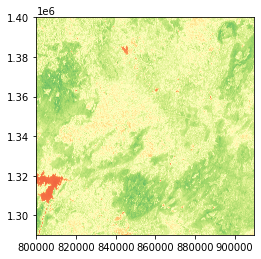

In [86]:
ndvi = rio.open(r'NDVI2.tif')
show(ndvi, transform=ndvi.transform, cmap='RdYlGn')

# Mask Satellite image

In [87]:
boundary_proj = boundary.to_crs({'init': 'epsg:32643'})

with rio.open("/content/NDVI2.tif") as src:
    out_image, out_transform = rio.mask.mask(src, boundary_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open("NDVI_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


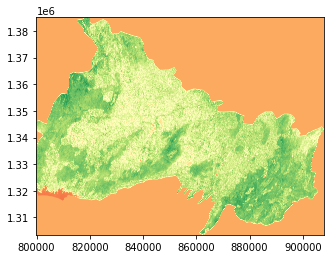

In [88]:
ndvi_mask = rio.open(r'NDVI_masked.tif')
show(ndvi_mask, transform=ndvi_mask.transform, cmap='RdYlGn')
